# Thierry Khamphousone 
### DataCamp Python - 01/12/2020

# K-means

## Algo
1. Define ```k``` and ```max_iter``` (maximum number of_iterations)
2. Compute *k* random centroids
3. Until max number of iterations not reached:
    - Assign to each training sample its nearest centroid
    - Udpate centroid coordinates

In [11]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

In [12]:
def distance_euclidienne(pt1, pt2):
    '''
    Euclidian distance between two points
    '''
    
    if not isinstance(pt1, np.ndarray) and not isinstance(pt2, np.ndarray):
        raise TypeError("inputs must be np.ndarray")
    if(len(pt1)!=len(pt2)):
        raise ValueError("inputs must have the same dimension")
    else:
        return np.sqrt(np.sum((pt1 - pt2)**2))

In [13]:
class myKnn:
    def __init__(self):
        self.train = None
        self.labels = None
        
    def apprentissage(self, X, y):
        '''
        lazy
        '''
        self.train = X
        self.labels = y
        
    def predict(self, X):
        predictions = []
        
        for test_sample in X:
            distances = []
            for train_sample in self.train:
                distances.append(distance_euclidienne(test_sample, train_sample))
            nearest_train_samples = np.argsort(distances)
        
            nearest_classes = []
        
            nearest_classes.append(self.labels[nearest_train_samples[0]])
            predictions.append(nearest_classes[0])
       
        return np.array(predictions)

In [62]:
class MyKmeans:
    '''
    desc: Implementation of Kmeans algorithm
    1.Define k and max_iter (maximum number of_iterations)
    2.Compute k random centroids
    3.Until max number of iterations not reached:
        - Assign to each training sample its nearest centroid
        - Udpate centroid coordinates
    '''
    def __init__(self, k, max_iter=100, verbose=False, random_state=42):
        self.k = k
        self.verbose = verbose
        self.rs = random_state
        self.centroids = None
        self.max_iter = max_iter
        self.labels = []
        self.classes = None
        self.inertia = None
        
        for c in range(self.k):
            self.labels.append('cluster {}'.format(c+1))
            
        if verbose:
            print('*****  Initialization of Kmeans with {} clusters  *****'.format(self.k))
            print('\tmax_iter: \t', self.max_iter)
            print('\tlabels: \t', self.labels)
            print('\trandom state: \t', self.rs)
            print('\tverbose: \t', self.verbose)                                 
            print('******************************************************')
    
    def fit(self, X):
        '''
        desc: This function trains kmeans on X with k clusters
            --> At the end, a label will be assigned to each sample of X and be stored in classes attribute
        '''
        # init centroids
        # cf. init_centroids function for more information
        ranges = []
        for j in range(len(X.columns)): #pour chaque feature (columns)
            ranges.append([X.min(0)[j], X.max(0)[j]])
      
        self.init_centroids(ranges)
        
        # until stopping criteria is reached ... : TODO
        A = X.iloc[:,0:len(X.columns)].values #convert dataframe -> array of Xi [[feature1, feature2], [...], ...]
        knn = myKnn()
        
        
        flag = False #flag to exit the for loop behind if convergence
        
        for tour in range(self.max_iter):
            # assign label to each sample
            
            knn.apprentissage(self.centroids, self.labels)
            current_clusters = knn.predict(A) # here are stored the current nearest cluster of each sample in X
                
            # update centroids coordinates 
            
            #initialisation de la liste de dataframes
            initlist=[0] * len(X.columns)
            new_centers = [pd.DataFrame([initlist])] * self.k
            
            #on retire la premiere ligne d'initialisation dans chacun des clusters
            for i in range(self.k): #pour chaque cluster de la liste de clusters,
                new_centers[i] = new_centers[0].iloc[1:,:] 
            
            #on ajoute les points qui font parti d'un tel cluster dans la list de dataframe respectivement
            for e in range(len(A)):
                for j in range(len(self.labels)):
                    if current_clusters[e] == self.labels[j]:
                        new_centers[j]=new_centers[j].append(pd.DataFrame(A[e]).transpose()) 
            
            
            #parcours de la liste de DataFrame afin d'en faire leur moyenne respectivement
            #on a maintenant une liste des moyennes de chaque cluster correspondant au nouveau centroïd 
            for r in range(len(new_centers)):
                new_centers[r]=np.mean(new_centers[r], axis=0).values #convert Pandas Series to Numpy Arrays
            
            class_of_current_clusters = self.labels #different class of clusters
            
            
            # looking for convergence
        
            count_true = 0 #on compte le nombre de clusters qui n'ont pas bougé
            for m in range(len(self.centroids)):

                if (self.centroids[m] == new_centers[m]).all():      #Test de sortie, si les centroids n'ont pas bougé
                    count_true+=1
                    if count_true == len(self.centroids): #si tous les clusters n'ont pas bougé
                        flag = True
                        break
            
            count_true = 0 #reset
            
            if flag == True:
                break
            
            self.centroids = new_centers # updating old centroids with new ones 
            new_centers = [] #reinitilisation des futurs centroids
            

        self.classes = current_clusters # here are stored the nearest cluster of each sample in X
        
        #computing inertia
        self.ssd(X)
        self.predict(X)
        
        if self.verbose:
            print('Model trained in {} iterations...'.format(tour+1))
            print('Inertia : ', self.inertia)
        
        
    def init_centroids(self, ranges):
        '''
        desc: Compute self.k random centroids defined within specified ranges
        each row in ranges correspond to a feature
        two columns in range (col1 : min value, col2 : max value)
        '''
        # Setting seed
        np.random.seed(self.rs)
        
        # Computing k centroids
        self.centroids = []
        temp = []
        for i in range(len(ranges)):
                temp.append(list(np.random.uniform(ranges[i][0], ranges[i][1], self.k)))
        temp = np.array(temp)
        temp_inv = np.transpose(temp).tolist()
        self.centroids = temp_inv
        
        #print(self.centroids)
        # for self.k == 2 clusters
        #            cluster 1 init                            cluster 2 init
        #[[60.693894499378224, 72.7354062975177], [130.98714538200977, 59.66853145130959]]
        #       feature 1      feature 2             feature 1     feature 2
            
        return self.centroids
    
    
    def ssd(self, X):
        '''
        Compute sum of squared distances (inertia)
        Used for elbow method
        X (df) must be the same size as the trained model input X (df)
        '''
        
        res=0
        distances_each_cluster = [0] * self.k #liste des distances entre Xi et le centroids de chaque cluster i
        A = X.iloc[:,0:len(X.columns)].values 
        
        for e in range(len(A)): #pour toutes les données Xi
            for j in range(len(self.labels)): #pour tous les clusters
                if self.classes[e] == self.labels[j]: #si la donnée appartient à un tel cluster
                    distances_each_cluster[j] += (distance_euclidienne(X.values[e], self.centroids[j])) ** 2
        
        for i in range(len(distances_each_cluster)):
            res+=distances_each_cluster[i]
        
        self.inertia = res
        
    def predict(self,X):
        '''
        Assign the nearest cluster to each sample of X
        Kmeans has to be trained before using this function
        '''
        predictions = self.classes
        
        return predictions

## 1. Visualisation des données

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

__a) Charger la base de données (Customers_practice.csv).__

In [8]:
df = pd.read_csv('Customers_practice.csv')
df.head(10)

,Annual_Income_(k$),Spending_Score
0,103,85
1,60,52
2,59,55
3,62,55
4,48,47
5,44,50
6,73,5
7,33,92
8,71,75
9,21,66


In [7]:
df.describe()

,Annual_Income_(k$),Spending_Score
count,170.000000,170.000000
mean,60.988235,50.141176
std,26.457958,25.944708
min,15.000000,1.000000
25%,42.250000,34.250000
50%,61.500000,50.000000
75%,78.000000,73.000000
max,137.000000,99.000000


__b) Afficher les 10 premières lignes du jeu de données (fonction head()). Déterminer le
nombre d’exemples, ainsi que le nombre de features pour ce problème.__

Nombre d'exemple : 170
Nombre de features : 2

In [5]:
import seaborn as sns
sns.set()

In [9]:
len(df.iloc[:,0].values)

170

__c) Afficher les données à l’aide d’un scatterplot (utiliser la librairie seaborn ou matplotlib). Vous devriez obtenir un graphe similaire à celui-ci (penser à la légende et au titre) :__

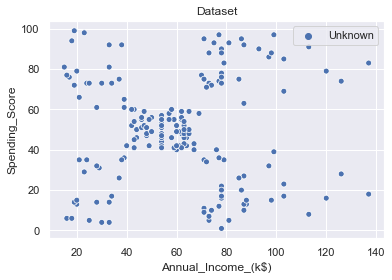

In [10]:
sns.scatterplot(df.iloc[:,0].values, df.iloc[:,1].values, hue=['Unknown']*len(df), s=35)
plt.xlabel('Annual_Income_(k$)')
plt.ylabel('Spending_Score')
plt.title('Dataset')
plt.show()

## 2. K-means algorithm

__a) Tester votre kmeans avec k=3, random_state=42. Utiliser la fonction fit() sur le dataset. Vous pouvez utiliser tout l’ensemble de données étant donné qu’il n’y a pas de labels.__

In [63]:
kmean = MyKmeans(3, 100, True, 42)

*****  Initialization of Kmeans with 3 clusters  *****
	max_iter: 	 100
	labels: 	 ['cluster 1', 'cluster 2', 'cluster 3']
	random state: 	 42
	verbose: 	 True
******************************************************


In [64]:
kmean.fit(df)

Model trained in 6 iterations...
Inertia :  91570.07313519815


__b) Une fois le modèle entraîné vous pouvez accéder aux labels assignés aux données avec l’attribut classes.__

In [65]:
#print(kmean.classes)

__c) Vous pouvez également accéder aux centroïdes (attribut centroids). Utiliser la fonction print() pour les afficher.__

In [66]:
print(kmean.centroids)

[array([44.35576923, 49.63461538]), array([86.84848485, 82.63636364]), array([87.54545455, 19.24242424])]


__d) Utiliser de nouveau la function scatterplot mais cette fois utilisez les labels fournis par votre kmeans entraîné pour distinguer les différents clusters :__

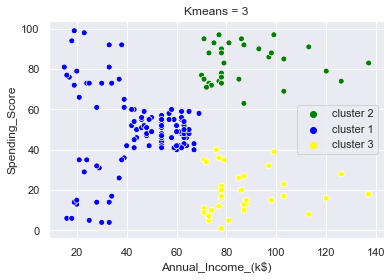

In [67]:
sns.set_palette(['green', 'blue', 'yellow'])
sns.scatterplot(df.iloc[:,0].values, df.iloc[:,1].values, hue=kmean.classes, s=35)
plt.xlabel('Annual_Income_(k$)')
plt.ylabel('Spending_Score')
plt.title('Kmeans = {}'.format(kmean.k))
plt.show()

__e) Expliquer pourquoi k=3 ne semble pas approprié comme nombre correct de clusters.__

k=3 ne semble pas approprié comme nombre de correct de cluster car sur le scatterplot, il semble y avoir plus de 3 clusters.

J'estime qu'un nombre de cluster k = 5 serait plus approprié comme nombre correct de clusters. 

__f) Trouver un moyen d’afficher également les centroïdes comme ci-dessous :__

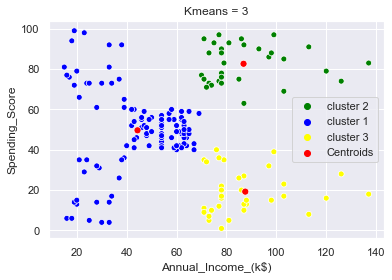

In [68]:
sns.set_palette(['green', 'blue', 'yellow'])
sns.scatterplot(df.iloc[:,0].values, df.iloc[:,1].values, hue=kmean.classes, s=35)

sns.set_palette(['red'])
sns.scatterplot(pd.DataFrame(kmean.centroids).iloc[:,0], pd.DataFrame(kmean.centroids).iloc[:,1], hue=['Centroids']*len(kmean.centroids), s=50)
plt.xlabel('Annual_Income_(k$)')
plt.ylabel('Spending_Score')
plt.title('Kmeans = {}'.format(kmean.k))

plt.show()

## 3. Trouver la valeur optimale de k

__Implémenter la function ssd (sum of squared distances) dans votre classe kmeans.__

Voir la fonction ssd de la classe Kmean

__a) En utilisant la base de données complète :__

__-Trouver la valeur optimale de k en utilisant la méthode du coude (utiliser l’intervalle suivant : [1,21[ ).__

In [17]:
inertia_k = []
current_min_inertia = 99999999

for i in range(1,21):
    for j in range(10,50):
        kmean = MyKmeans(i, 100, False, j)
        kmean.fit(df)
        if kmean.inertia < current_min_inertia:
            current_min_inertia = kmean.inertia
    inertia_k.append(current_min_inertia)
    current_min_inertia = 99999999
    print(i, end=" ")

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

In [25]:
print(inertia_k)

[232062.5882352941, 157029.66625121172, 91570.07313519815, 63536.39984989211, 38565.488856528675, 31553.501372997707, 25013.401581605533, 20836.81333680453, 18537.689061669324, 16496.21255957665, 14778.660199542554, 13293.566459031166, 12010.262677368064, 11086.313095238096, 11315.670180799594, 9235.262177528353, 9353.648349330408, 7791.658088235294, 7862.484110791171, 7214.725968933028]


__- Dessiner la courbe obtenue (graphe attendu ci-dessous):__

In [26]:
import matplotlib.pyplot as plt

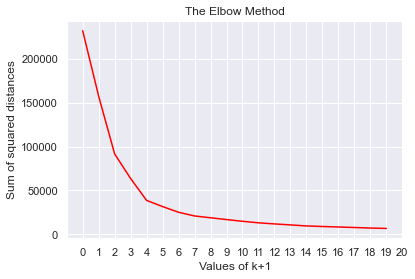

In [115]:
plt.plot(inertia_k);
plt.title('The Elbow Method')
plt.ylabel('Sum of squared distances')
plt.xlabel('Values of k+1')
plt.margins(x=0.05, y=0.05) 
plt.xticks(np.arange(0, 21, 1.0));

__-Conclure sur la meilleure valeur pour k.__

La meilleure valeur pour k correspond à un changement important de la pente de la courbe avant qu'elle devienne quasi constante.

Ici, pour moi, __la meilleure valeur de k correspondrait à k = 5.__

__En effet le graphe débute à k + 1 = 1, soit 0 + 1 = 1__


__b) Entraîner votre kmeans avec le k optimal trouvé précédemment :__

__- random_state=42__

__- Dessiner le scatterplot associé__

__- Observer et décrire les clusters obtenus en fonction des axes (e.g. le cluster 1 représente les clients ayant des revenus faibles mais réalisant un grand nombre de transactions)__

In [9]:
best_kmean = MyKmeans(5, 100, True, 42)

*****  Initialization of Kmeans with 5 clusters  *****
	max_iter: 	 100
	labels: 	 ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5']
	random state: 	 42
	verbose: 	 True
******************************************************


In [15]:
best_kmean.fit(df)

Model trained in 9 iterations...
Inertia :  38565.488856528675


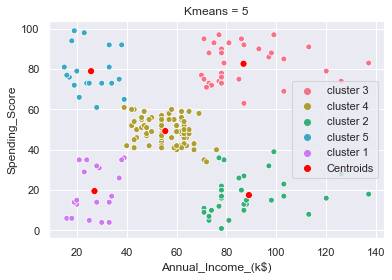

In [18]:
sns.set_palette(['green', 'blue', 'yellow'])
sns.scatterplot(df.iloc[:,0].values, df.iloc[:,1].values, hue=best_kmean.classes, s=35)

sns.set_palette(['red'])
sns.scatterplot(pd.DataFrame(best_kmean.centroids).iloc[:,0], pd.DataFrame(best_kmean.centroids).iloc[:,1], hue=['Centroids']*len(best_kmean.centroids), s=50)

plt.xlabel('Annual_Income_(k$)')
plt.ylabel('Spending_Score')
plt.title('Kmeans = {}'.format(best_kmean.k))
plt.show()

__- Le cluster 1__ représente les clients ayant des __revenus faibles__ et réalisant un __faible nombre de transactions__.

__- Le cluster 2__ représente les clients ayant des __revenus élevés__ et réalisant un __faible nombre de transactions__.

__- Le cluster 3__ représente les clients ayant des __revenus élevés__ et réalisant un __fort nombre de transactions__.

__- Le cluster 4__ représente les clients ayant des __revenus modérés__ et réalisant un  __nombre de transactions modérés__.

__- Le cluster 5__ représente les clients ayant des __revenus faibles__ et réalisant un __fort nombre de transaction__.

## 4. Pas de partie 4

## 5 Aller plus loin

__Charger les données (Customers_practice_test.csv).__

In [21]:
dftest = pd.read_csv('Customers_practice_test.csv')

,Annual_Income_(k$),Spending_Score
0,62,42
1,19,3
2,48,50
3,87,75
4,88,69
5,67,57
6,20,77
7,29,87
8,69,91
9,101,68


In [22]:
dftest.head(10)

,Annual_Income_(k$),Spending_Score
0,62,42
1,19,3
2,48,50
3,87,75
4,88,69
5,67,57
6,20,77
7,29,87
8,69,91
9,101,68


In [23]:
dftest.shape

(30, 2)

__a) Utiliser votre kmeans qui a été entraîné avec le k optimal (trouvé dans la partie 4) afin de prédire une classe pour les exemples tests chargés.__

In [278]:
km = MyKmeans(5, 100, True, 43)
km.fit(dftest)

*****  Initialization of Kmeans with 5 clusters  *****
	max_iter: 	 100
	labels: 	 ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5']
	random state: 	 43
	verbose: 	 True
******************************************************
Model trained in 5 iterations...
Inertia :  5288.400000000001


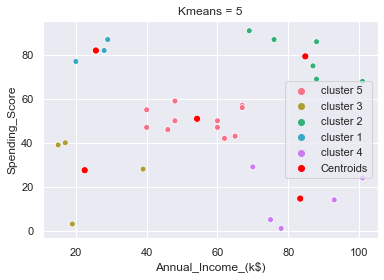

In [279]:
sns.set_palette(['green', 'blue', 'yellow'])
sns.scatterplot(dftest.iloc[:,0].values, dftest.iloc[:,1].values, hue=km.classes, s=35)

sns.set_palette(['red'])
sns.scatterplot(pd.DataFrame(km.centroids).iloc[:,0], pd.DataFrame(km.centroids).iloc[:,1], hue=['Centroids']*len(km.centroids), s=50)

plt.xlabel('Annual_Income_(k$)')
plt.ylabel('Spending_Score')
plt.title('Kmeans = {}'.format(km.k))
plt.show()

__a bis) Utiliser le kmeans de Sklearn afin de prédire une classe pour les exemples tests chargés.__

In [232]:
kms = KMeans(n_clusters=5, random_state=43).fit(dftest)

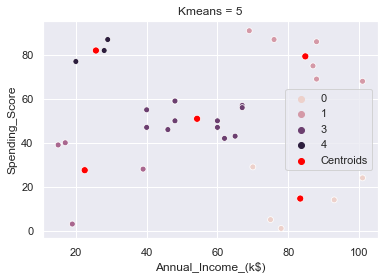

In [233]:
sns.set_palette(['green', 'blue', 'yellow'])
sns.scatterplot(dftest.iloc[:,0].values, dftest.iloc[:,1].values, hue=kms.labels_, s=35)

sns.set_palette(['red'])
sns.scatterplot(pd.DataFrame(kms.cluster_centers_).iloc[:,0], pd.DataFrame(kms.cluster_centers_).iloc[:,1], hue=['Centroids']*len(kms.cluster_centers_), s=50)

plt.xlabel('Annual_Income_(k$)')
plt.ylabel('Spending_Score')
plt.title('Kmeans = {}'.format(kms.n_clusters))
plt.show()

__b) Utiliser la fonction save() pour générer le fichier resultats.csv__

In [274]:
def save(predictions):
    '''
    predictions of kmeans
    '''
    column = ['prediction']
    res_df = pd.DataFrame(predictions, columns=column)
    print(res_df)
    res_df.to_csv('resultats.csv', index=None)

In [275]:
save(km.classes) # execute the cell to generate resultats.csv

   prediction
0   cluster 5
1   cluster 3
2   cluster 5
3   cluster 2
4   cluster 2
5   cluster 5
6   cluster 1
7   cluster 1
8   cluster 2
9   cluster 2
10  cluster 5
11  cluster 5
12  cluster 1
13  cluster 5
14  cluster 5
15  cluster 2
16  cluster 4
17  cluster 3
18  cluster 5
19  cluster 4
20  cluster 3
21  cluster 5
22  cluster 2
23  cluster 4
24  cluster 4
25  cluster 5
26  cluster 5
27  cluster 3
28  cluster 4
29  cluster 5


__c) Dessiner les frontières de décisions (exemple ici avec k=3)__

__[3:08 PM] GONZALEZ Jordan__
> L'idée c'est de générer une grille de points dans l'espace de représentation de vos données. 
> Et chacun de ces points sera considéré comme une donnée test. 
>
> Vous utilisez alors votre classifieur entrainé dessus pour prédire une classe pour chacun de ces points. 
> Et on plot le tout en les distingant selon leurs couleurs. 
>
> Il y a des fonctions utiles comme contour et contourf. 
> Bon courage

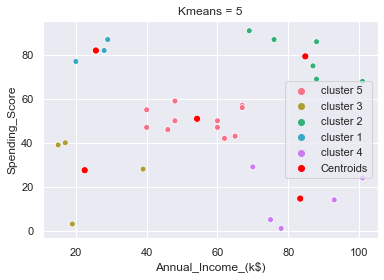

In [316]:
sns.set_palette(['green', 'blue', 'yellow'])
sns.scatterplot(dftest.iloc[:,0].values, dftest.iloc[:,1].values, hue=km.classes, s=35)

sns.set_palette(['red'])
sns.scatterplot(pd.DataFrame(km.centroids).iloc[:,0], pd.DataFrame(km.centroids).iloc[:,1], hue=['Centroids']*len(km.centroids), s=50)

#for i in range(5):
#    plt.contour(vb ==i, contours=1,colors=['b'])
#plt.pcolormesh(dftest.iloc[:,0].values, dftest.iloc[:,1].values, km.classes)

plt.xlabel('Annual_Income_(k$)')
plt.ylabel('Spending_Score')
plt.title('Kmeans = {}'.format(km.k))
plt.show()

# Discussion - M. Gonzalez

__[1:49 PM] GONZALEZ Jordan__

> avez-vous lancé le kmeans de sklearn et utlisé leur attribut (inertia_) pour dessiner aussi un elbow plot pour comparer ?
    
__[1:50 PM] GONZALEZ Jordan__

> ça serait intéressant de voir ce que ça donne

__[1:55 PM] GONZALEZ Jordan__

> Lancer le sklearn kmeans et dessinez leur elbow plot pour comparer (dans la doc ça doit être inertia_ l'attribut permettant d'accéder au ssd). 

In [108]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=5, random_state=42).fit(df.values)
kmeans.cluster_centers_
kmeans.inertia_

38565.48885652868

J'obtiens ici le même résultat que mon KMeans

In [109]:
inertia_k = []
current_min_inertia = 99999999

for i in range(1,21):
    for j in range(42,43):
        kmeans = KMeans(n_clusters=i, random_state=j).fit(df.values)
        if kmeans.inertia_ < current_min_inertia:
            current_min_inertia = kmeans.inertia_
    inertia_k.append(current_min_inertia)
    current_min_inertia = 99999999
    print(i, end=" ")

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

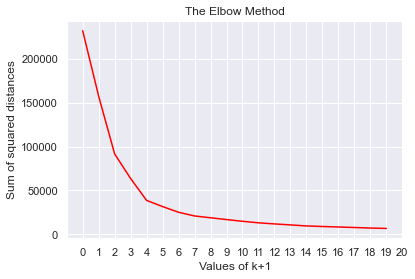

In [116]:
plt.plot(inertia_k);
plt.title('The Elbow Method')
plt.ylabel('Sum of squared distances')
plt.xlabel('Values of k+1')
plt.margins(x=0.05, y=0.05) 
plt.xticks(np.arange(0, 21, 1.0));

J'obtiens ici le même coude qu'avec mon KMeans
Le coude semble se placer au niveau de k = 5 qui est bien ce que j'ai obtenu avant

__[1:55 PM] GONZALEZ Jordan__

> Essayez également l'exercice suivant :
>
> - faites kmeans k=4 et calculer une valeur de calinski (chercher calinski harabz skleran sur le net), 
>
> - faites également kmeans k=5 et calculer de nouveau une valeur de calinski. 
>
>   (4,5 c'est finalement la zone d'indécision pour vous ici)

## the Calinski-Harabasz index (sklearn.metrics.calinski_harabasz_score) 
#### - also known as the Variance Ratio Criterion 
#### - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters

In [123]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
kmeans_model = KMeans(n_clusters=4, random_state=1).fit(df.values)
labels = kmeans_model.labels_
metrics.calinski_harabasz_score(df.values, labels)

146.7680853708524

Pour __k=4__, j'obtiens un score de __Calinski Harabasz__ égal à __146.8__

In [125]:
kmeans_model = KMeans(n_clusters=5, random_state=1).fit(df.values)
labels = kmeans_model.labels_
metrics.calinski_harabasz_score(df.values, labels)

206.96626922240762

Pour __k=5__, j'obtiens un score de __Calinski Harabasz__ égal à __206.97__

In [126]:
kmeans_model = KMeans(n_clusters=6, random_state=1).fit(df.values)
labels = kmeans_model.labels_
metrics.calinski_harabasz_score(df.values, labels)

204.76687422904413

Pour __k=6__, j'obtiens un score de __Calinski Harabasz__ égal à __204.77__

__Conlusion__

On a bien __k=5 le nombre de cluster optimal__ pour notre model car __le score de Calinski-Harabasz évalué est le plus grand__ parmi k=4, k=5 et k=6.